# Seattle non-residential buildings energy consumption

This notebook aims at predicting the total energy consumptions of non-residential buildings in the city of Seattle.
It relies on an official dataset available here: https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy
We are using a modified (by us) version of the database that you can find at this adress: inserer lien github

Another almost identical notebook exists and deals with GHG emissions rather than Energy consumption.

## Initialization

In [1]:
# Packages import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

In [2]:
# Loading the dataset
data = pd.read_csv(r'./Data/seattle_cleaned_dataset.csv', sep = ',', low_memory = False)

In [3]:
data.describe()

,OSEBuildingID,ZipCode,Latitude,Longitude,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,BuildingAge
count,1636.000000,1620.000000,1636.000000,1636.000000,1636.000000,1636.000000,1.636000e+03,1636.000000,1.636000e+03,1078.000000,1636.000000,1.636000e+03,1.636000e+03,1.636000e+03,1.636000e+03,1.636000e+03,1636.000000,1636.000000,1636.000000
mean,16255.489609,98116.932716,47.616126,-122.332965,1.099633,4.118582,1.137481e+05,12945.718826,1.008023e+05,65.138219,75.018949,7.970777e+06,8.122033e+06,4.700248e+05,5.475530e+06,1.997737e+06,180.552152,1.626333,52.827628
std,13854.775408,18.533239,0.048417,0.024662,1.161766,6.565362,1.941333e+05,42535.544496,1.728464e+05,28.379155,74.910480,2.170728e+07,2.219025e+07,5.156614e+06,1.339365e+07,9.453094e+06,708.466267,2.352106,32.526775
min,1.000000,98006.000000,47.499170,-122.411820,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,-1.154170e+05,0.000000e+00,-0.800000,-0.020000,0.000000
25%,577.750000,98105.000000,47.585160,-122.343335,1.000000,1.000000,2.950550e+04,0.000000,2.852325e+04,48.000000,36.099998,1.251083e+06,1.322253e+06,0.000000e+00,7.272688e+05,0.000000e+00,20.427500,0.360000,26.000000
50%,21131.000000,98110.000000,47.612380,-122.332890,1.000000,2.000000,4.971200e+04,0.000000,4.763750e+04,73.000000,54.299999,2.582214e+06,2.736046e+06,0.000000e+00,1.628064e+06,5.141630e+05,50.015000,0.880000,49.000000
75%,24591.500000,98125.000000,47.649760,-122.321765,1.000000,4.000000,1.060102e+05,0.000000,9.506750e+04,89.000000,85.299997,6.928335e+06,7.187220e+06,0.000000e+00,4.882877e+06,1.529470e+06,144.870000,1.910000,85.000000
max,50226.000000,98199.000000,47.733870,-122.258640,27.000000,99.000000,2.200000e+06,512608.000000,2.200000e+06,100.000000,834.400024,4.483853e+08,4.716139e+08,1.349435e+08,2.745325e+08,2.979090e+08,16870.980000,34.090000,115.000000


As minimums of Electricity(kBtu) and TotalGHGEmissions, we find negative values. As previously investigated, it corresponds to the Bullit Center, self-designated as "the Greenest Commercial Building in the World". Indeed, on average for a given year, it produces more energy that it requires to operate.

After having run some tests, we'll remove it from the dataset as it induces important variations in the estimations results when it's part of the training set vs part of the test set. We'll do the same with the huge Boeing factory, as well as other observations that are rare and could be considered problematic outliers.

Text(0.5, 1.0, 'GHG Emissions vs Total GFA')

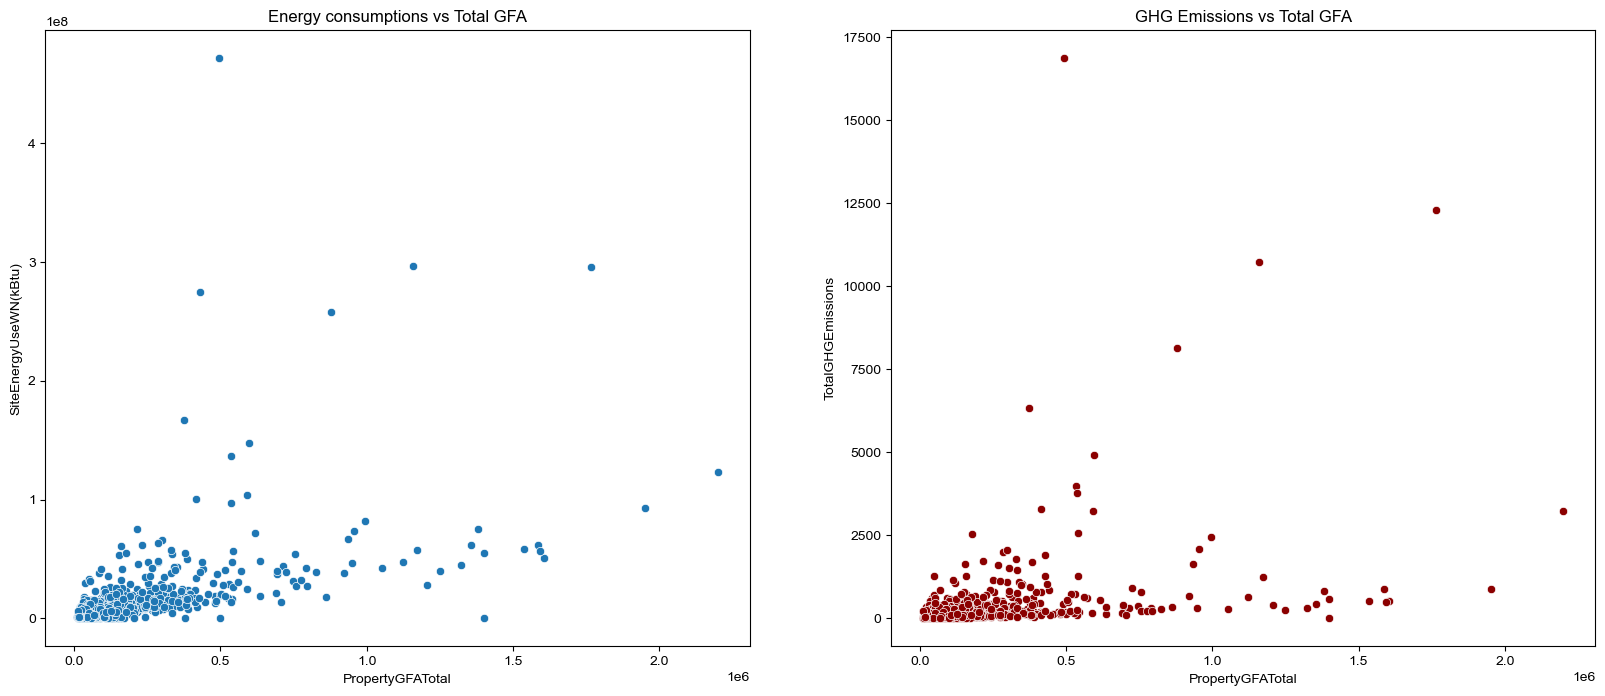

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.set_style("darkgrid")

sns.scatterplot(data=data, x='PropertyGFATotal', y='SiteEnergyUseWN(kBtu)', ax=axes[0])
axes[0].set_title("Energy consumptions vs Total GFA", color='black')

sns.scatterplot(data=data, x='PropertyGFATotal', y='TotalGHGEmissions', ax=axes[1], color="darkred")
axes[1].set_title("GHG Emissions vs Total GFA", color='black')

In [5]:
data = data[~(data['Electricity(kBtu)'] <= 0)] # Deletion of the Bullit Center and potential others
data = data[data['SiteEnergyUse(kBtu)'] < 2*10**8] # Deletion of outliers

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1619 entries, 0 to 1635
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OSEBuildingID              1619 non-null   int64  
 1   PrimaryPropertyType        1619 non-null   object 
 2   PropertyName               1619 non-null   object 
 3   Address                    1619 non-null   object 
 4   ZipCode                    1603 non-null   float64
 5   Neighborhood               1619 non-null   object 
 6   Latitude                   1619 non-null   float64
 7   Longitude                  1619 non-null   float64
 8   NumberofBuildings          1619 non-null   float64
 9   NumberofFloors             1619 non-null   int64  
 10  PropertyGFATotal           1619 non-null   int64  
 11  PropertyGFAParking         1619 non-null   int64  
 12  PropertyGFABuilding(s)     1619 non-null   int64  
 13  ListOfAllPropertyUseTypes  1619 non-null   objec

All variables seems to be coded in the proper format.

We have some missing values for ZipCode, LargestPropertyUseType, and ENERGYSTARScore. We'll delete Zipcode (as well as other localization/id variables) but keep the two other.

## Preprocessing

In [7]:
# Exclude some 'id' and localization variables for now
data = data.drop(['OSEBuildingID', 'PropertyName', 'Address', 'ZipCode', 'ComplianceStatus'], axis = 1)

Some buildings have 0 as a value for SiteEnergyUse and therefore for SiteEnergyUseWN, we will delete them.

In [8]:
data = data[~(data['SiteEnergyUseWN(kBtu)'] == 0)]
data = data[~(data['SiteEnergyUse(kBtu)'] == 0)]

Also, a building has 0 consumption of steam, natural gas and electricity, which is not possible. We delete it as well.

In [9]:
data = data[~(data['SiteEnergyUseWN(kBtu)'] == 12843856.0)]

#### Numerical vs Categorical features decomposition

In [10]:
# Categorical features
categorical_features = data[['PrimaryPropertyType', 'Neighborhood', 
                             'ListOfAllPropertyUseTypes', 'LargestPropertyUseType']]
categorical_features.nunique()

PrimaryPropertyType           21
Neighborhood                  19
ListOfAllPropertyUseTypes    358
LargestPropertyUseType        54
dtype: int64

As seen in the data exploration notebook, there are a lot of PropertyUseTypes (362). On the other hand, PrimaryPropertyType (with 21 unique values) may be a little to innacurate.  
In between, LargestPropertyUseType has a interesting 55 unique values and will be retained as our 'building type' variable. So we have to delete the four observations that do not have a value for this feature.

In [11]:
data = data[~(data['LargestPropertyUseType'].isnull())]

In [12]:
categorical_features = data[['Neighborhood', 'LargestPropertyUseType']]

In [13]:
# Numerical features
numerical_features = data[['Latitude', 'Longitude',
                           'NumberofBuildings', 'NumberofFloors', 'BuildingAge',
                           'PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)',
                           'SiteEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)',
                           'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
                           'TotalGHGEmissions', 'GHGEmissionsIntensity',
                           'ENERGYSTARScore']]

The retained numerical features for sure present multicolinearity. For example, the PropertyGFATotal is positively correlated with the NumberofBuildings.
Including both will not a problem with regards to the overall performance and prediction power of the model, but it will blur the explanation impact of each variable. We should keep that in mind.

ENERGYSTARScore will recieve a special treatment due to its relative low number of observations.

Our target is the energy consumption. Tow variables measure that: 'SiteEUIWN(kBtu/sf)' and 'SiteEnergyUseWN(kBtu)'.
We will take the gross energy consumption: 'SiteEnergyUseWN(kBtu)' as feature to predict. The 'energy use intensity' ('SiteEUIWN(kBtu/sf)') will be deleted. Correspondingly, we are going to use 'SiteEnergyUse(kBtu)' (non-weather normalized) to transform SteamUse(kBtu), Electricity(kBtu) and NaturalGas(kBtu) with their respective share in energy use. 

Similarly, the GHGEmissions (raw and intensity) are also highly correlated with consumptions, and must be removed.

In [14]:
data['elec_share'] = data['Electricity(kBtu)'] / data['SiteEnergyUse(kBtu)']
data['gas_share'] = data['NaturalGas(kBtu)'] / data['SiteEnergyUse(kBtu)']
data['steam_share'] = data['SteamUse(kBtu)'] / data['SiteEnergyUse(kBtu)']

Because we have another notebook to develop (GHG Emissions), we will save the dataset at this point of the data preparation so we can load it at the begining of the GHG Emissions' notebook.

In [15]:
# CSV export
data.to_csv('./Data/seattle_modeling_dataset.csv', index = False)

#### Train & Test sets

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

X = data[['Latitude', 'Longitude', 
          'NumberofBuildings', 'NumberofFloors', 'BuildingAge',
          'PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)',
          'elec_share', 'gas_share', 'steam_share',
          'Neighborhood', 'LargestPropertyUseType']]

y = RobustScaler().fit_transform(data[['SiteEnergyUseWN(kBtu)']]) # after several tries, we keep this y transformation
#y = np.log(data['SiteEnergyUseWN(kBtu)'])
#y = data['SiteEnergyUseWN(kBtu)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Models

We will include all remaining preprocessing in pipelines.

First, we are going to run several linear models: a LinearRegression (as baseline model), Ridge, Lasso and an ElasticNet regression.
Then, we will implement two ensemble methods: a Random Forest and a Gradient Boost.

All R², MAE and RMSE will be stored in a table to compare results, as well as training time for each model. 

In [17]:
# Selected Scikit-Learn modules
# Pipeline tools
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import TransformedTargetRegressor

# Transformers
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

# Linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

# Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Linear models

### Baseline model: Linear Regression

In [18]:
# Transformer
transformer = make_column_transformer(
                                      (RobustScaler(),  
                                       # We choose the robust scaler because we have outliers
                                       # that we want to keep
                                              ['Latitude', 'Longitude', 
                                               'NumberofBuildings', 'NumberofFloors', 'BuildingAge',
                                               'PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)',
                                               'elec_share', 'gas_share', 'steam_share'
                                              ]),   
                                      (OneHotEncoder(handle_unknown='ignore'),
                                       # we decide to ignore unknown categories because some building types are
                                       # unique, and therefore only exist
                                       # in either the test or the train set.
                                              ['Neighborhood', 'LargestPropertyUseType'])
                                     )


This transformer is going ot be used in all linear_models.

In [19]:
## Linear Regression
start = time.time()

# Model fitting
model_lr = make_pipeline(transformer, LinearRegression())
                     
model_lr.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

# Predictions
y_pred = model_lr.predict(X_test)

# Results
Linear_Regression_base_results = {'Algorithm' : 'Linear Regression_base', 
                             'R² Train' : model_lr.score(X_train, y_train),
                             'R² Test' : model_lr.score(X_test, y_test),   
                             'MAE' : mean_absolute_error(y_test, y_pred), 
                             'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                             'Training time (sec)' : training_time}

Results_table = pd.DataFrame.from_dict([Linear_Regression_base_results])
Results_table

,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.718618,0.598005,0.601125,1.288293,0.031269


The linear regression model performs quite poorly. We will try a cross-validation to see if any improvement occurs before moving to different modelizations.

In [20]:
# Cross-validation - Linear Regression
from sklearn.model_selection import GridSearchCV
start = time.time()

params = {'linearregression__fit_intercept' : [True, False]}
grid = GridSearchCV(model_lr, param_grid = params, cv=5)
grid.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

y_pred = grid.predict(X_test)

Linear_Regression_CV_results = {'Algorithm' : 'Linear Regression', 
                             'R² Train': grid.score(X_train, y_train),
                             'R² Test' : grid.score(X_test, y_test), 
                             'MAE' : mean_absolute_error(y_test, y_pred), 
                             'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                             'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([Linear_Regression_CV_results]))
Results_table

C:\Users\Gregoire\AppData\Local\Temp\ipykernel_10852\491490831.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results_table = Results_table.append(pd.DataFrame.from_dict([Linear_Regression_CV_results]))


,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.718618,0.598005,0.601125,1.288293,0.031269
0,Linear Regression,0.718618,0.598005,0.601125,1.288293,0.331818


The implementation of a 5-fold cross-validation and a fit of an intercept or not has not changed the result much. Let's try a more sophisticated model.

### Ridge regression

In [21]:
from sklearn.linear_model import Ridge
warnings.filterwarnings('ignore')
start = time.time()

# Cross-validated - Ridge Regression
alphas = np.logspace(-5, 1, num = 50)
params = {'ridge__alpha' : alphas}

model_ridge = make_pipeline(transformer, Ridge())
    
grid = GridSearchCV(model_ridge, param_grid = params, cv=5)

grid.fit(X_train, y_train)
   
stop = time.time()
training_time = stop-start

y_pred = grid.predict(X_test)

Ridge_Regression_results = {'Algorithm' : 'Ridge Regression', 
                             'R² Train' : grid.score(X_train, y_train),
                             'R² Test' : grid.score(X_test, y_test), 
                             'MAE' : mean_absolute_error(y_test, y_pred), 
                             'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                             'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([Ridge_Regression_results]))
Results_table

,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.718618,0.598005,0.601125,1.288293,0.031269
0,Linear Regression,0.718618,0.598005,0.601125,1.288293,0.331818
0,Ridge Regression,0.147510,0.070227,1.073138,1.959263,4.942703


The Ridge results are very bad, despite a cross validation. Let's switch to Lasso

### Lasso Regression

In [22]:
from sklearn.linear_model import Lasso
warnings.filterwarnings('ignore')
start = time.time()

# Cross-validated - Lasso Regression
alphas = np.logspace(-5, 1, num = 50)
params = {'lasso__alpha' : alphas}

model_lasso = make_pipeline(transformer, Lasso())

grid = GridSearchCV(model_lasso, param_grid = params, cv=5)
grid.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

y_pred = grid.predict(X_test)

Lasso_Regression_results = {'Algorithm' : 'Lasso Regression', 
                             'R² Train' : grid.score(X_train, y_train),
                             'R² Test' : grid.score(X_test, y_test), 
                             'MAE' : mean_absolute_error(y_test, y_pred), 
                             'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                             'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([Lasso_Regression_results]))
Results_table

,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.718618,0.598005,0.601125,1.288293,0.031269
0,Linear Regression,0.718618,0.598005,0.601125,1.288293,0.331818
0,Ridge Regression,0.147510,0.070227,1.073138,1.959263,4.942703
0,Lasso Regression,0.698897,0.604354,0.578632,1.278079,32.028032


### Lasso CV

In [23]:
from sklearn.linear_model import LassoCV
warnings.filterwarnings('ignore')
start = time.time()

# Automatically cross-validated - Lasso Regression
alphas = np.logspace(-5, 1, num = 50)

model_lassoCV = make_pipeline(transformer, LassoCV(alphas=alphas))
model_lassoCV.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

y_pred = model_lassoCV.predict(X_test)

Lasso_Regression_CV_results = {'Algorithm' : 'Lasso Regression_autoCV', 
                             'R² Train' : model_lassoCV.score(X_train, y_train), 
                             'R² Test' : model_lassoCV.score(X_test, y_test), 
                             'MAE' : mean_absolute_error(y_test, y_pred), 
                             'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                             'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([Lasso_Regression_CV_results]))
Results_table

,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.718618,0.598005,0.601125,1.288293,0.031269
0,Linear Regression,0.718618,0.598005,0.601125,1.288293,0.331818
0,Ridge Regression,0.147510,0.070227,1.073138,1.959263,4.942703
0,Lasso Regression,0.698897,0.604354,0.578632,1.278079,32.028032
0,Lasso Regression_autoCV,0.707769,0.607764,0.573039,1.272559,6.936226


The two Lasso models barely reach the performance of our baseline regression. By combining Lasso and Ridge regularizations we might be able to have better results. Let's implement an ElasticNet

### ElasticNet

In [24]:
#warnings.filterwarnings('ignore')

# Model fitting
start = time.time()
model_EN = make_pipeline(transformer, ElasticNet())
model_EN.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

# Predictions
y_pred = model_EN.predict(X_test)

# Results
ElasticNet_noCV_results = {'Algorithm' : 'Elastic Net_noCV', 
                             'R² Train' : model_EN.score(X_train, y_train), 
                             'R² Test' : model_EN.score(X_test, y_test), 
                             'MAE' : mean_absolute_error(y_test, y_pred), 
                             'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                             'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([ElasticNet_noCV_results]))
Results_table

,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.718618,0.598005,0.601125,1.288293,0.031269
0,Linear Regression,0.718618,0.598005,0.601125,1.288293,0.331818
0,Ridge Regression,0.147510,0.070227,1.073138,1.959263,4.942703
0,Lasso Regression,0.698897,0.604354,0.578632,1.278079,32.028032
0,Lasso Regression_autoCV,0.707769,0.607764,0.573039,1.272559,6.936226
0,Elastic Net_noCV,0.521811,0.492837,0.724646,1.447032,0.013113


Without any tuning of the hyperparameters, the ElasticNet model is outperformed by the standard Linear regression. We will now try to improve it's result with a proper cross validation.

In [25]:
# Cross-validation - ElasticNet Regression
warnings.filterwarnings('ignore')
start = time.time()

alphas = [0.002811768697974231]
l1_ratios = [0]

params = {'elasticnet__max_iter' : [100],
          'elasticnet__alpha' : alphas,
          'elasticnet__l1_ratio' : l1_ratios}

grid = GridSearchCV(model_EN, param_grid = params, cv=5)
grid.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

y_pred = grid.predict(X_test)

print(grid.best_params_)


ElasticNet_results = {'Algorithm' : 'Elastic Net', 
                             'R² Train' : grid.score(X_train, y_train), 
                             'R² Test' : grid.score(X_test, y_test), 
                             'MAE' : mean_absolute_error(y_test, y_pred), 
                             'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                             'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([ElasticNet_results]))
Results_table

{'elasticnet__alpha': 0.002811768697974231, 'elasticnet__l1_ratio': 0, 'elasticnet__max_iter': 100}


,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.718618,0.598005,0.601125,1.288293,0.031269
0,Linear Regression,0.718618,0.598005,0.601125,1.288293,0.331818
0,Ridge Regression,0.147510,0.070227,1.073138,1.959263,4.942703
0,Lasso Regression,0.698897,0.604354,0.578632,1.278079,32.028032
0,Lasso Regression_autoCV,0.707769,0.607764,0.573039,1.272559,6.936226
0,Elastic Net_noCV,0.521811,0.492837,0.724646,1.447032,0.013113
0,Elastic Net,0.702990,0.613342,0.600180,1.263478,0.218780


With different settings, the ElasticNet is now way better performing, but still barely reaching the Lasso and the baseline models. Moreover, it takes quite long to train. 
Considering the question we study, this long training time isn't an issue (we won't compute consumptions predictions every single day), but the gain is very marginal in terms of reducing the bias and variance.

## Ensemble methods

### Random Forest, no Cross-validation

In [26]:
from sklearn.ensemble import RandomForestRegressor
#warnings.filterwarnings('ignore')

start = time.time()

model_RF = make_pipeline(transformer, RandomForestRegressor())

model_RF.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

y_pred = model_RF.predict(X_test)


RandomForest_nocv_results = {'Algorithm' : 'Random Forest_noCV', 
                        'R² Train' : model_RF.score(X_train, y_train), 
                        'R² Test' : model_RF.score(X_test, y_test), 
                        'MAE' : mean_absolute_error(y_test, y_pred), 
                        'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                        'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([RandomForest_nocv_results]))
Results_table

,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.718618,0.598005,0.601125,1.288293,0.031269
0,Linear Regression,0.718618,0.598005,0.601125,1.288293,0.331818
0,Ridge Regression,0.147510,0.070227,1.073138,1.959263,4.942703
0,Lasso Regression,0.698897,0.604354,0.578632,1.278079,32.028032
0,Lasso Regression_autoCV,0.707769,0.607764,0.573039,1.272559,6.936226
0,Elastic Net_noCV,0.521811,0.492837,0.724646,1.447032,0.013113
0,Elastic Net,0.702990,0.613342,0.600180,1.263478,0.218780
0,Random Forest_noCV,0.954124,0.639512,0.533786,1.219972,2.179459


### Random Forest with CV

In [27]:
##warnings.filterwarnings('ignore')
#start = time.time()
#
#model_RF = make_pipeline(transformer, RandomForestRegressor())
#
#params = {'randomforestregressor__n_estimators' : [50, 100, 300, 500],
#          'randomforestregressor__min_samples_split' : [2, 3, 4],
#          'randomforestregressor__max_features' : ['auto', 'sqrt', '1.0'],
#          'randomforestregressor__oob_score' : ['True', 'False']}
#
#grid = GridSearchCV(model_RF, param_grid = params, cv=5)
#grid.fit(X_train, y_train)
#
#stop = time.time()
#training_time = stop-start
#
#y_pred = grid.predict(X_test)
#
#print(grid.best_params_)
#
#
#RandomForest_results = {'Algorithm' : 'Random Forest', 
#                        'R² Train' : grid.score(X_train, y_train), 
#                        'R² Test' : grid.score(X_test, y_test), 
#                        'MAE' : mean_absolute_error(y_test, y_pred), 
#                        'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
#                        'Training time (sec)' : training_time}
#
#Results_table = Results_table.append(pd.DataFrame.from_dict([RandomForest_results]))
#Results_table

In [28]:
#warnings.filterwarnings('ignore')
start = time.time()

model_RF = make_pipeline(transformer, RandomForestRegressor())

params = {'randomforestregressor__n_estimators' : [100],
          'randomforestregressor__min_samples_split' : [2],
          'randomforestregressor__max_features' : ['sqrt'],
          'randomforestregressor__oob_score' : ['False']}

grid = GridSearchCV(model_RF, param_grid = params, cv=5)
grid.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

y_pred = grid.predict(X_test)

print(grid.best_params_)


RandomForest_results = {'Algorithm' : 'Random Forest', 
                        'R² Train' : grid.score(X_train, y_train), 
                        'R² Test' : grid.score(X_test, y_test), 
                        'MAE' : mean_absolute_error(y_test, y_pred), 
                        'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                        'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([RandomForest_results]))
Results_table

{'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__oob_score': 'False'}


,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.718618,0.598005,0.601125,1.288293,0.031269
0,Linear Regression,0.718618,0.598005,0.601125,1.288293,0.331818
0,Ridge Regression,0.147510,0.070227,1.073138,1.959263,4.942703
0,Lasso Regression,0.698897,0.604354,0.578632,1.278079,32.028032
0,Lasso Regression_autoCV,0.707769,0.607764,0.573039,1.272559,6.936226
0,Elastic Net_noCV,0.521811,0.492837,0.724646,1.447032,0.013113
0,Elastic Net,0.702990,0.613342,0.600180,1.263478,0.218780
0,Random Forest_noCV,0.954124,0.639512,0.533786,1.219972,2.179459
0,Random Forest,0.952336,0.614569,0.569307,1.261472,2.954611


Clearly, there is a huge improvement when we switch to ensemble methods.
The random forest regressor out-performs every single other model we fitted, and by far.
It's interesting to note that the cross-validation slightly improves the random forest's mean absolute error, but decreases a bit both R² and RMSE.

Let's now see if the boosting methods are as good.

### Gradient Boost

In [29]:
###    Because this piece of code has a runtime of more than two hours, 
###    we ran it only once to get the best parameters.
#
#from sklearn.ensemble import GradientBoostingRegressor
#warnings.filterwarnings('ignore')
#
#start = time.time()
#
#model_GB = make_pipeline(transformer, GradientBoostingRegressor())
#lambdas = np.logspace(-5, 1, num = 50)
#
#params = {'gradientboostingregressor__n_estimators' : [500],
#          'gradientboostingregressor__learning_rate' : lambdas,
#          'gradientboostingregressor__min_samples_leaf' : [1,3],
#          'gradientboostingregressor__max_depth' : [3,5],
#          }
#
#grid = GridSearchCV(model_GB, param_grid = params, cv=5)
#grid.fit(X_train, y_train)
#
#stop = time.time()
#training_time = stop-start
#
#y_pred = grid.predict(X_test)
#
#print(grid.best_params_)
#
#
#GradientBoost_results = {'Algorithm' : 'Gradient Boosting_lr150', 
#                        'R² Train' : grid.score(X_train, y_train), 
#                        'R² Test' : grid.score(X_test, y_test), 
#                        'MAE' : mean_absolute_error(y_test, y_pred), 
#                        'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
#                        'Training time (sec)' : training_time}
#
#Results_table = Results_table.append(pd.DataFrame.from_dict([GradientBoost_results]))
#Results_table

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

start = time.time()

model_GB = make_pipeline(transformer, GradientBoostingRegressor())
lambdas = [0.2598]

params = {'gradientboostingregressor__n_estimators' : [500],
          'gradientboostingregressor__learning_rate' : lambdas,
          'gradientboostingregressor__min_samples_leaf' : [3],
          'gradientboostingregressor__max_depth' : [3],
         }

grid = GridSearchCV(model_GB, param_grid = params, cv=5)
grid.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

y_pred = grid.predict(X_test)

print(grid.best_params_)


GradientBoost_results = {'Algorithm' : 'Gradient Boosting_best_params', 
                        'R² Train' : grid.score(X_train, y_train), 
                        'R² Test' : grid.score(X_test, y_test), 
                        'MAE' : mean_absolute_error(y_test, y_pred), 
                        'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                        'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([GradientBoost_results]))
Results_table

{'gradientboostingregressor__learning_rate': 0.2598, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__min_samples_leaf': 3, 'gradientboostingregressor__n_estimators': 500}


,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.718618,0.598005,0.601125,1.288293,0.031269
0,Linear Regression,0.718618,0.598005,0.601125,1.288293,0.331818
0,Ridge Regression,0.147510,0.070227,1.073138,1.959263,4.942703
0,Lasso Regression,0.698897,0.604354,0.578632,1.278079,32.028032
0,Lasso Regression_autoCV,0.707769,0.607764,0.573039,1.272559,6.936226
0,Elastic Net_noCV,0.521811,0.492837,0.724646,1.447032,0.013113
0,Elastic Net,0.702990,0.613342,0.600180,1.263478,0.218780
0,Random Forest_noCV,0.954124,0.639512,0.533786,1.219972,2.179459
0,Random Forest,0.952336,0.614569,0.569307,1.261472,2.954611
0,Gradient Boosting_best_params,0.997844,0.640132,0.575648,1.218921,6.672049


As we can see, the Gradient Boost model is highly performing, with very little training time when the best-parameters have been identified.
Aststated before, and considering the scope of the project (predicting future consumptions/emissions), a very slow model can be used because it doesn't need to be trained that often.
Therefore, the Gradient Boost model is the one we keep as final predictor.

### Energy Star score

Although our mission is to evaluate the impact of the ESS on emissions, we'll also see if consumptions predictions are improved with the addition of this indicator.

Note that we only have 1062 observations, we have to filter again the whole dataset and re-do the split and predictions.
We'll use our best model to do so.

In [31]:
data_ESS = data[~(data['ENERGYSTARScore'].isnull())]

In [32]:
X = data_ESS[['Latitude', 'Longitude', 
          'NumberofBuildings', 'NumberofFloors', 'BuildingAge',
          'PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)',
          'elec_share', 'gas_share', 'steam_share',
          'ENERGYSTARScore',
          'Neighborhood', 'LargestPropertyUseType']]

y = RobustScaler().fit_transform(data_ESS[['SiteEnergyUseWN(kBtu)']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [33]:
# Transformer
transformer = make_column_transformer(
                                      (RobustScaler(),  
                                       # We choose the robust scaler because we have outliers
                                       # that we want to keep
                                              ['Latitude', 'Longitude', 
                                               'NumberofBuildings', 'NumberofFloors', 'BuildingAge',
                                               'PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)',
                                               'elec_share', 'gas_share', 'steam_share',
                                               'ENERGYSTARScore'
                                              ]),   
                                      (OneHotEncoder(handle_unknown='ignore'),
                                       # we decide to ignore unknown categories because some building types are
                                       # unique, and therefore only exist
                                       # in either the test or the train set.
                                              ['Neighborhood', 'LargestPropertyUseType'])
                                     )


In [34]:
from sklearn.ensemble import GradientBoostingRegressor

start = time.time()

model_GB = make_pipeline(transformer, GradientBoostingRegressor())
lambdas = [0.2598]

params = {'gradientboostingregressor__n_estimators' : [500],
          'gradientboostingregressor__learning_rate' : lambdas,
          'gradientboostingregressor__min_samples_leaf' : [3],
          'gradientboostingregressor__max_depth' : [3],
         }

grid = GridSearchCV(model_GB, param_grid = params, cv=5)
grid.fit(X_train, y_train)

stop = time.time()
training_time = stop-start

y_pred = grid.predict(X_test)

print(grid.best_params_)


GradientBoost_results = {'Algorithm' : 'Gradient Boosting_ESS_best_params', 
                        'R² Train' : grid.score(X_train, y_train),
                        'R² Test' : grid.score(X_test, y_test), 
                        'MAE' : mean_absolute_error(y_test, y_pred), 
                        'RMSE' : np.sqrt(mean_squared_error(y_test, y_pred)),
                        'Training time (sec)' : training_time}

Results_table = Results_table.append(pd.DataFrame.from_dict([GradientBoost_results]))
Results_table

{'gradientboostingregressor__learning_rate': 0.2598, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__min_samples_leaf': 3, 'gradientboostingregressor__n_estimators': 500}


,Algorithm,R² Train,R² Test,MAE,RMSE,Training time (sec)
0,Linear Regression_base,0.718618,0.598005,0.601125,1.288293,0.031269
0,Linear Regression,0.718618,0.598005,0.601125,1.288293,0.331818
0,Ridge Regression,0.147510,0.070227,1.073138,1.959263,4.942703
0,Lasso Regression,0.698897,0.604354,0.578632,1.278079,32.028032
0,Lasso Regression_autoCV,0.707769,0.607764,0.573039,1.272559,6.936226
0,Elastic Net_noCV,0.521811,0.492837,0.724646,1.447032,0.013113
0,Elastic Net,0.702990,0.613342,0.600180,1.263478,0.218780
0,Random Forest_noCV,0.954124,0.639512,0.533786,1.219972,2.179459
0,Random Forest,0.952336,0.614569,0.569307,1.261472,2.954611
0,Gradient Boosting_best_params,0.997844,0.640132,0.575648,1.218921,6.672049


Adding the EnergyStarScore has a very high impact on the RMSE, with a really improved prediction power, despite the relative low number of observations compared to the full datset.

### Features importance

We are going to use the SHAP package to capture each feature impact on our predictions.

In [35]:
import shap

shap.initjs()

In [36]:
X = data_ESS[['Latitude', 'Longitude', 
          'NumberofBuildings', 'NumberofFloors', 'BuildingAge',
          'PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)',
          'elec_share', 'gas_share', 'steam_share',
          'ENERGYSTARScore',
          'Neighborhood', 'LargestPropertyUseType']]

y = RobustScaler().fit_transform(data_ESS[['SiteEnergyUseWN(kBtu)']])

# Kind of OneHotEncoding to bypass some SHAP issues with pipelines
X = pd.concat([X, pd.get_dummies(X['Neighborhood'], prefix = 'Ngbh', dummy_na=True)],axis=1).drop(['Neighborhood'],axis=1)
X = pd.concat([X, pd.get_dummies(X['LargestPropertyUseType'], prefix = 'Usage', dummy_na=True)],axis=1).drop(['LargestPropertyUseType'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

We consider only the best model: gradient boost, and therefore use a TreeExplainer from SHAP package.

In [37]:
# Explainer
estimator = grid.best_estimator_.named_steps["gradientboostingregressor"]
explainer = shap.TreeExplainer(estimator)

In [38]:
# Calculatin shap values
shap_values = explainer.shap_values(X_train)

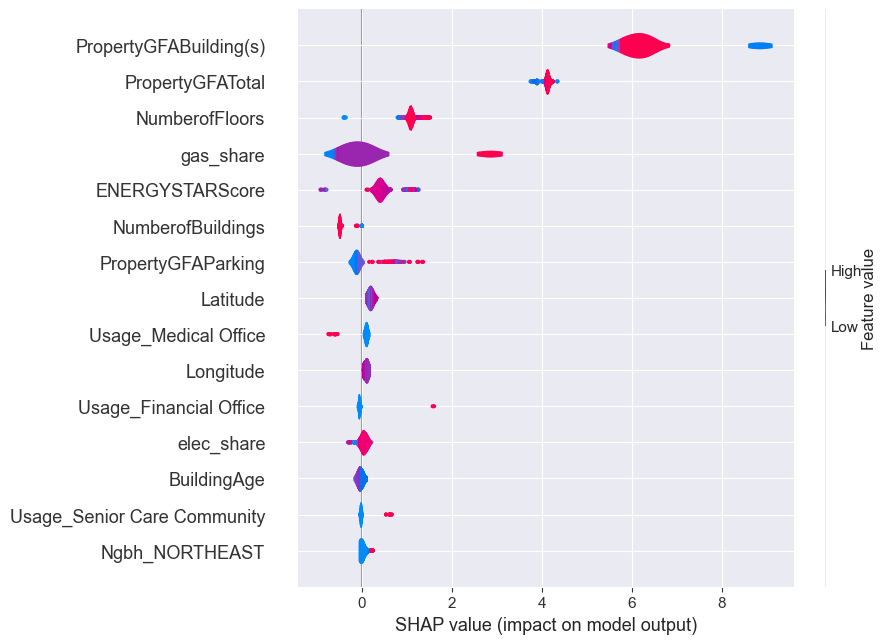

In [42]:
# Visualization
shap.summary_plot(shap_values,
                  plot_type = 'violin',
                  features = X_train,
                max_display = 15)